In [1]:
import pandas as pd
import geopandas as gpd

In [2]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)
gdf = gdf[gdf.Basin_Numb == "5-021"]

<Axes: >

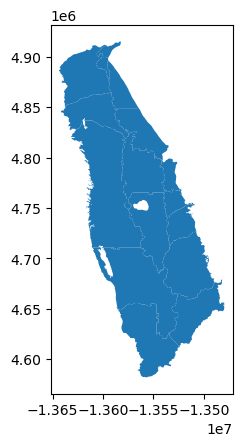

In [4]:
gdf.plot()

In [5]:
gdf

,Basin_Numb,Basin_Subb,Basin_Name,Basin_Su_1,Region_Off,Date_Recor,Record_Edi,Comments,Date_Data_,GlobalID,Shape__Are,Shape__Len,Area_Acres,Area_SqMil,geometry,Basin_Prefix
OBJECTID,,,,,,,,,,,,,,,,
5,5-021,5-021.69,SACRAMENTO VALLEY,SACRAMENTO VALLEY - WYANDOTTE CREEK,NRO,2019-01-04,CBC,2018 BBIDS,None,{278388F3-8BE2-495B-8992-204523B419A6},4.032181e+08,131478.411800,59382,92.785,"POLYGON ((-13529349.986 4795531.366, -13528912...",5
163,5-021,5-021.50,SACRAMENTO VALLEY,SACRAMENTO VALLEY - RED BLUFF,NRO,2015-07-09,ESmith,The eastern and southern basin boundaries were...,None,{AE8C202A-FEC6-4C71-B16A-4BD7DB881431},1.882164e+09,246190.219749,271793,424.678,"POLYGON ((-13598191.976 4910095.897, -13598250...",5
259,5-021,5-021.61,SACRAMENTO VALLEY,SACRAMENTO VALLEY - SOUTH YUBA,NCRO,2018-12-18,SE,2018 BBIDS,None,{7C56AA6D-1942-4540-B3F9-9EB3DF6045AB},7.332276e+08,172567.983517,109020,170.344,"POLYGON ((-13513641.157 4753876.4, -13513599.6...",5
270,5-021,5-021.52,SACRAMENTO VALLEY,SACRAMENTO VALLEY - COLUSA,NRO,2021-12-06,CBC,2021 Colusa Basin Boundary Correction,None,{8013D946-E48A-4A72-B550-6294F68289E1},4.895974e+09,700293.268269,722785,1129.352,"POLYGON ((-13619850.24 4833900.714, -13619844....",5
286,5-021,5-021.65,SACRAMENTO VALLEY,SACRAMENTO VALLEY - SOUTH AMERICAN,NCRO,2018-10-29,CBC,2018 BBIDS,None,{FEC526DD-E3B6-4390-8314-C1DA8CC469DD},1.642360e+09,263395.997759,248403,388.130,"POLYGON ((-13481883.696 4675484.426, -13481944...",5
287,5-021,5-021.66,SACRAMENTO VALLEY,SACRAMENTO VALLEY - SOLANO,NCRO,2018-10-29,CBC,2018 BBIDS,None,{26DA8135-F2DB-4CCD-8928-5D3F8F102771},2.333962e+09,306572.072838,354672,554.176,"POLYGON ((-13567634.614 4655707.377, -13567572...",5
300,5-021,5-021.67,SACRAMENTO VALLEY,SACRAMENTO VALLEY - YOLO,NCRO,2018-10-26,CBC,2018 BBIDS,None,{0BE58575-7FC5-4870-9A86-6A0D564DAA5F},3.594910e+09,510055.867589,540693,844.833,"POLYGON ((-13602691.665 4710924.329, -13602708...",5
334,5-021,5-021.51,SACRAMENTO VALLEY,SACRAMENTO VALLEY - CORNING,NRO,2018-11-30,ACuthbertson,2018 BBIDS,None,{283AC3A7-F17A-4030-9725-465F31284822},1.425483e+09,249165.572653,207342,323.973,"POLYGON ((-13591449.757 4864105.907, -13591416...",5
402,5-021,5-021.62,SACRAMENTO VALLEY,SACRAMENTO VALLEY - SUTTER,NCRO,2019-01-04,CBC,2018 BBIDS,None,{E1649466-6630-40DA-9A9B-43DCD1A36755},1.921804e+09,330657.124615,285809,446.578,"POLYGON ((-13554572.721 4765323.685, -13554529...",5
